# Exercise 3: Run HBV model with ERA5 forcing and GRDC observation

In this notebook you will run your own HBV model using ERA5 forcing data (from the previous notebook) and GRDC observation data. You will have to change a few settings below. Read carefully and decide which inputs and lines you need to change.

In [1]:
# Load all dependencies, including your own model through ewatercycle_wrapper_HBV
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import matplotlib.pyplot as plt
import xarray as xr

from ewatercycle_wrapper_HBV import HBV
 


/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser/settings_lat_lon-Run.xml does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /data/shared/parameter-sets/pcrglobwb_rhinemeuse_30min does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-p

Add the name of your region in the cell below:

In [2]:
# Name of your shapefile/region without extension:
own_region = "HN4326" #for example: "Rhine"

if own_region == None: # if nothing is provided, the Rhine shapefile will be used
    own_region = "Rhine"

In [3]:
# Shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"
shapeFile = forcing_path / f"{own_region}.shp"

# Location to saved forcing results from previous notebook
forcingLocation = forcing_path / f"{own_region}Forcing"

# GRDC station ID for the observation station
grdc_station_id = "5204302"  # GRDC station ID
basin_name = own_region

# Period of interest. Make sure that GRDC data is available for this period and that.
experiment_start_time = "2010-01-01T00:00:00Z"
experiment_end_time = "2014-12-31T00:00:00Z"

Forcing was created in the previous notebook and loaded here.

In [4]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2010-01-01T00:00:00Z',
    end_time='2014-12-31T00:00:00Z',
    directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326Forcin
g'),
    shape=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326Forcing/HN
4326.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2010-2014.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2010-2014.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2010-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

Now we can prepare the configuration files just as in the first notebook. Note that we are using the same parameters as in the first notebook which will not be adequate for your new area (but might be pretty ok, let's see!):

In [5]:
s_0 = np.array([0,  100,  0,  5])

p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]

param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

par_0 = (p_min_initial + p_max_initial)/2

In [6]:
model = HBV(forcing=ERA5_forcing)

In [7]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [8]:
model.initialize(config_file)

/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:56: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


Now it is time again to run the HBV model:

In [9]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    discharge_this_timestep = model.get_value("Q")
    Q_m.append(discharge_this_timestep[0])
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [10]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"], index=time)

We can plot the output discharge directly using the DataFrame.

Text(0.5, 0, 'Time')

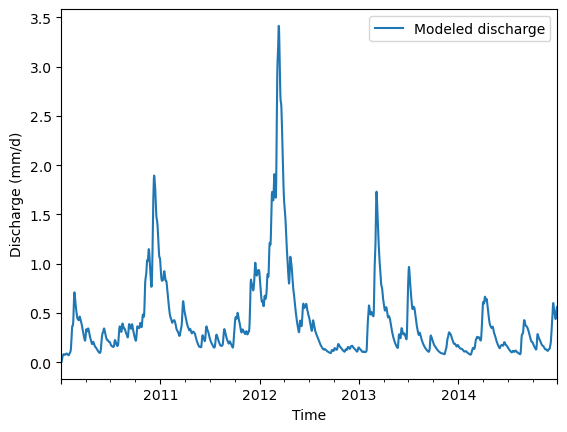

In [11]:
fig, ax = plt.subplots(1,1)

df.plot(ax=ax,label="Modeled discharge HBV-bmi")
plt.ylabel(f"Discharge ({model.bmi.get_var_units('Q')})")
plt.xlabel("Time")

## Analyse results
We can also use the ```hydrograph``` function from eWaterCycle. This will make a hydrograph that compares model output to observations. For this we need to load observations and make sure that the observations and model output are in the same units. Observations typically are in m$^3$/s. 

Note that the unit of discharge from this model is in mm/d. Conversion to m$^3$/s requires the area of the catchment.

In [12]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["AREA"]
print("The catchment area is:", shape_area)

The catchment area is: 20874888631.0

The hydrograph function requires xarrays. We use the DataFrame ```df``` and convert the discharge to m$^3$ per second. Then we convert it to a ```xarray```

In [13]:
df['model output'] = df['Modeled discharge'] * shape_area / (1000 * 86400)
sim_data = df['model output'].to_xarray().rename({'index': 'time'}) 
sim_data.name = 'Simulated data'

df['model output']

2010-01-02      0.506795
2010-01-03      2.312593
2010-01-04      5.817178
2010-01-05     10.111538
2010-01-06     13.627539
                 ...    
2014-12-27    119.534361
2014-12-28    128.833160
2014-12-29    135.106478
2014-12-30    135.998020
2014-12-31    132.729127
Name: model output, Length: 1825, dtype: float64

The observation data is loaded using ```the get_grdc_data()``` function build into eWaterCycle. The GRDC data is given as a xarray object. The observation data and discharge data are combined together into one xarray. Note that we re-index the discharge data to make sure they are at the same timestamp.

In [25]:
df_obs = pd.read_csv("5202145_Q_Day.Cmd.txt",sep = ";", skiprows = 36, index_col=0, usecols=[0,2], parse_dates=[0], encoding="latin-1")
observations = df_obs[" Value"].loc["2010-01-02" : "2014"].copy()
observations.index.names=['time']
#observations.rename(columns={" Value": "Observations from GRDC"}, inplace=True)

print(observations.index)

DatetimeIndex(['2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05',
               '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09',
               '2010-01-10', '2010-01-11',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='time', length=1825, freq=None)

In [26]:
# Convert your Series to a DataArray, and give it a name:
obs_da = observations.to_xarray().rename("Observations from GRDC")

# Then merge:
discharge = xr.merge([sim_data, obs_da]).to_dataframe()


In [27]:
print(discharge.index)

DatetimeIndex(['2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05',
               '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09',
               '2010-01-10', '2010-01-11',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='time', length=1825, freq=None)

In [28]:
#observations = ewatercycle.observation.grdc.get_grdc_data(
    # station_id=grdc_station_id,
    # start_time=experiment_start_time,
    # end_time=experiment_end_time,
    # column='Observations from GRDC',
# )

In [29]:
#pd.concat([df['model output'], df_obs[" Value"] ])            

Have a look at the DataFrame with the model output and the observations from GRDC:

In [30]:
#discharge = xr.merge([sim_data, observations["Observations from GRDC"]]).to_dataframe()
hydro_data = discharge[["Observations from GRDC", "Simulated data"]].dropna()
#hydro_data = hydro_data.droplevel(0)

hydro_data

,Observations from GRDC,Simulated data
time,,
2010-01-02,0.627,0.506795
2010-01-03,0.550,2.312593
2010-01-04,0.508,5.817178
2010-01-05,0.546,10.111538
2010-01-06,0.627,13.627539
...,...,...
2014-12-27,2.000,119.534361
2014-12-28,2.105,128.833160
2014-12-29,1.191,135.106478


In [31]:
print(hydro_data.index)


DatetimeIndex(['2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05',
               '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09',
               '2010-01-10', '2010-01-11',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='time', length=1825, freq=None)

Finally plot the hydrograph. It is remarkabe to see how well a simple model like HBV, without calibration, is already able to predict discharge in the Rhine. Is it also good for your own area? 

(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

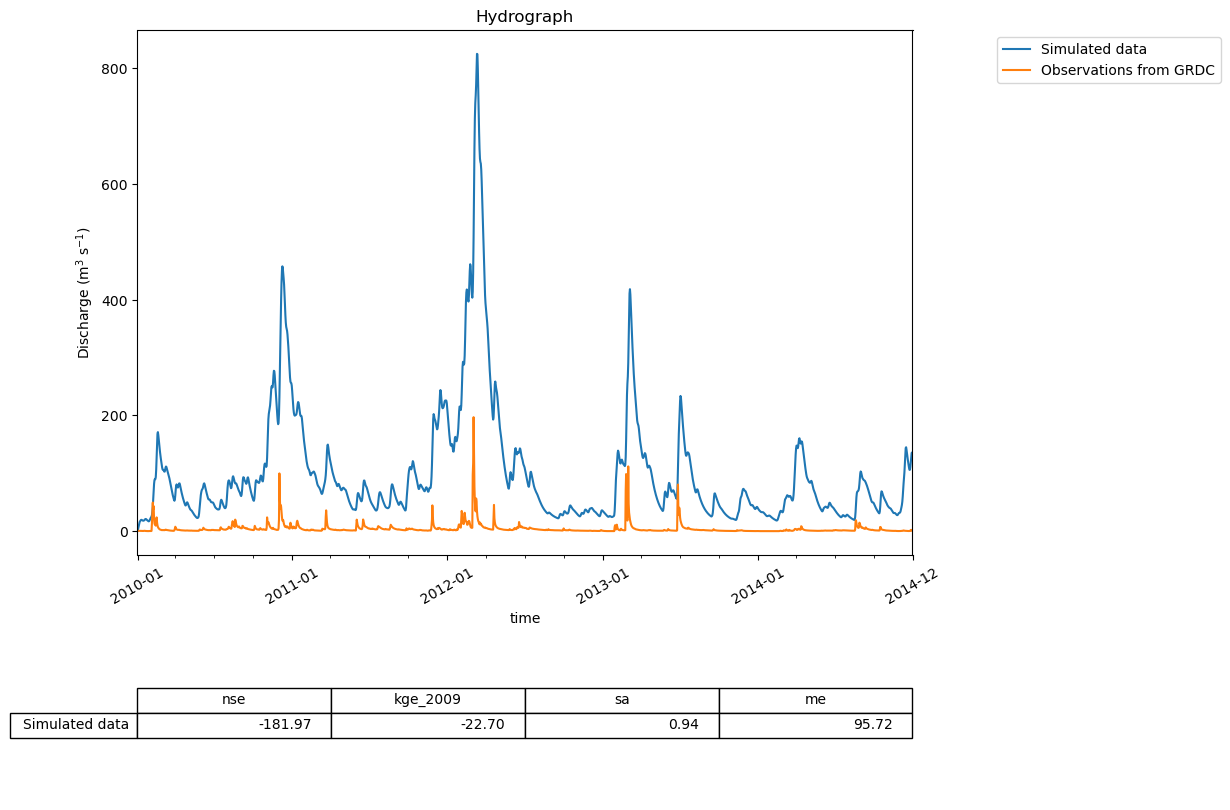

In [32]:
# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [33]:
model.finalize()